In [39]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import find_peaks

np.random.seed(1337) # for reproducibility

######----PROCESSING DATA------########
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

def generate_crossings_data(dir_path, time_range = None, window = 5000, step = 10):
    
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_crossings = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_crossings


def generate_data(dir_path, time_range, window = 2000, step = 10):
    
    moving_mean = generate_mean_data(dir_path, time_range, window = window, step = step)
    moving_sd = generate_sd_data(dir_path, time_range, window = window, step = step)
    time_label = load_time_label(dir_path, time_range, window = window, step = step)
    
    all_data = np.concatenate((moving_mean, moving_sd), axis = 1)
    
    print("All data's shape: ", all_data.shape)
    
    %reset -f in
    
    return all_data, time_label

#####-------INCREMENTAL LEARNING IMPLEMENTATION-------######

def create_threshold_list(trigger_sections, start_thres = 4.0, end_thres = 2.6):
    
    increment = (start_thres - end_thres)/(trigger_sections-3)
    
    trigger_thres = [0,0] #No trigger in the first two sections
    
    trigger_thres.extend([start_thres - i*increment for i in range(trigger_sections - 2)])
    
    return trigger_thres

def create_model():
    
    #================BUILD THE MODEL====================
    # Simple model
    # Simple model
    model = models.Sequential()

    model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_dim=12))

    model.add(Dense(3,activation='elu',
                    kernel_initializer='glorot_uniform', name = 'latent_space'))

    model.add(Dense(6,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(12,
                    kernel_initializer='glorot_uniform'))

    model.compile(loss='mse',optimizer='adam')


    return model

def get_latent_output(model_weights, X):
    
    model = create_model()  # create the original model
    model.set_weights(model_weights)

    layer_name = 'latent_space'
    intermediate_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_layer_model.compile(loss='mse',optimizer='adam')
    
    intermediate_output = intermediate_layer_model.predict(X)
    
    return intermediate_output

def train(current_weights, X, time_axis, time_range):
    """Take a model, train it in the appropritate time range, return the new weights
    and its reconstruction loss distribution"""
    
    print("Training for section: ", time_range)
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    X_train = np.copy(X[start_index:end_index])
    time_train = time_axis[start_index:end_index]
    
    #Create model
    model = create_model()
    
    if current_weights:
        model.set_weights(current_weights)
    
    #Scaler initiation
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    
    #Train the model and extract new weights
    model.fit(X_train, X_train,
              batch_size=2000,
              epochs=30, verbose = 0)
    
    new_weights = model.get_weights()
    
    #Evaluate the losses and update the distribution
    X_pred = model.predict(X_train)
    loss = np.mean(np.abs(X_pred-X_train), axis = 1)
    
    #Plot the reconstruction loss
    plt.figure(figsize=(20,2))
    plt.plot(time_train, loss)
    plt.title("TRAINING reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Take the mean of the log loss and update the mean threshold
    current_median = np.median(np.log10(loss))
    
    print("Finished training, median of the log(loss) is: ", current_median)
    
    return new_weights, current_median, scaler

def trigger(trigger_threshold, current_weights, X, time_axis, time_range, prev_median, scaler):
    
    print("Triggering for section: ", time_range)
    print("Using this median for triggering:", prev_median)
    print("Triggering threshold is: ", trigger_threshold)
    
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    time_test = time_axis[start_index:end_index]
    X_test = np.copy(X[start_index:end_index])
    
    X_test = scaler.transform(X_test) #Scale the current data
    
    #Create model
    model = create_model()
    model.set_weights(current_weights)
        
    #Find the test loss (doing this in parallel for the sake of simulation), but in a practical system
    #Ideally we need to do inference every single data point come in
    X_pred_test = model.predict(X_test)
    test_loss = np.mean(np.abs(X_pred_test-X_test), axis = 1)
    
    #Get latent space output
    latent_space = get_latent_output(current_weights, X_test)
    
    
    #Plot the reconstruction loss just to check
    plt.figure(figsize=(20,2))
    plt.plot(time_test, test_loss)
    plt.title("Reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Quantify how much each data point is away from the distribution
    log_test_loss = np.log10(test_loss) - prev_median
    
    #Find the trigger time
    trigger_index = np.argmax(log_test_loss > trigger_threshold)
    
    if  trigger_index != 0:
        #Plot the triggered time
        plt.figure(figsize=(20,2))
        plt.plot(time_test, log_test_loss, color = "firebrick")
        plt.title("Log reconstruction loss on {}".format(time_range))
        plt.xlabel("Time [s]")
        
        #Trigger time
        plt.vlines(time_test[trigger_index], log_test_loss.min(), log_test_loss.max(), color = "blue", linestyles = "dashed", label = "Trigger time")
        plt.legend(loc = "upper left")
        
        
        ### Find trigger times
        peaks, _ = find_peaks(log_test_loss, height=trigger_threshold, distance = 5000)
        print("Other trigger time: ", time_test[peaks])
        print("Their log loss values are: ", log_test_loss[peaks])
        
        for i in range(len(peaks)):
            plt.vlines(time_test[peaks[i]], log_test_loss.min(), log_test_loss.max(), color = "blue", linestyles = "dashed")
            
        plt.show()
        
        #Get latent space of normal data points
        normal_latent = np.delete(latent_space, peaks, 0)
        
        return list(time_test[peaks]), latent_space[peaks], normal_latent
    
    else:
        return None, None, None

def plot_3d_latent(latent_normal_coord, latent_coor):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(latent_normal_coord[:,0], latent_normal_coord[:,1], latent_normal_coord[:,2],
               color = 'deepskyblue', label = "normal latent")
    ax.scatter(latent_coor[:,0], latent_coor[:,1], latent_coor[:,2],
               color = 'red', label = "anomaly latent", alpha = 1, marker = 's', s = 50)
    
    plt.title("Latent space of normal vs abnormal points")
    plt.legend(loc = "best")
    plt.show()

def simulation(dir_path, section_size, time_range, reached_max):
    
    #Load data and create the model
    X, time_axis = generate_data(dir_path, time_range = time_range, window = 2000, step = 10)
    
    #For updating model
    current_weights = None
    new_weights = None
    
    #For keeping track of distribution history
    prev_median = None
    updated_median = None
    
    #Keeping track of scaler after training
    past_scaler = None
    
    #Calculate number of sections
    num_section = int(abs(time_range[0])/section_size)
    print("Number of sections:", num_section)
    
    #Keeping log of all the trigger time
    trigger_log = []
    
    #Keep track of latent coordinate of trigger time
    latent_coor = None
    
    #Keep track of normal latent space
    latent_normal_coord = None
    
    #Setting dynamic trigger threshold
    start_time = time_range[0]
    
    changing_range = abs(start_time - reached_max)
    
    trigger_sections = int(changing_range/section_size - (changing_range/section_size)%1)
    
    print("Number of triggering sections", trigger_sections)
    
    trigger_thres = create_threshold_list(trigger_sections, start_thres = 5.0, end_thres = 2.6)
    
    print("List of trigger thresholds: ", trigger_thres)
    
    #Sequentially go through the data
    for i in range(num_section):
        
        print("Entering sections: ", (-section_size*(num_section - i), -section_size*(num_section - i - 1)))
        print("-------->")
        
        if i == 0:
            continue
        elif i == 1:
            #Train on the first segment
            time_range = (None, -section_size*(num_section - i))
            new_weights, updated_median, new_scaler = train(current_weights, X, time_axis, time_range)
        else:
            
            #Set previous distrubution to the newly trained disttribution
            prev_median = updated_median
            current_scaler = new_scaler
            current_weights = new_weights
            
            #Selecting appropriate time range for training and triggering
            train_time_range = (-section_size*(num_section - i + 1), -section_size*(num_section - i))
            trigger_time_range = (-section_size*(num_section - i), -section_size*(num_section - i - 1))
            
            #Train and predict simutaneously
            new_weights, updated_median, new_scaler = train(current_weights, X, time_axis, train_time_range)
               
            #Select the trigger threshold
            
            if i >= len(trigger_thres):
                trigger_threshold = trigger_thres[-1]
            else:
                trigger_threshold = trigger_thres[i]
                
            
            trigger_time, trigger_latent, normal_latent = trigger(trigger_threshold, current_weights, X, time_axis, trigger_time_range, prev_median, current_scaler)
            
            if trigger_time is not None:
                print("Triggered at: ", trigger_time)
                trigger_log.extend(trigger_time)
                
                print("Latent coordinates are: ", trigger_latent)
                
                if latent_coor is None:
                    latent_coor = trigger_latent
                else:
                    latent_coor = np.append(latent_coor, trigger_latent, 0)
                
                print("latent_coor's shape: ", latent_coor.shape)
                
                if latent_normal_coord is None:
                    latent_normal_coord = normal_latent
                else:
                    latent_normal_coord = np.append(latent_normal_coord, normal_latent, 0)
                
                print("Latent_normal_coord's shape: ", latent_normal_coord.shape)
                
                #Plot the latent space at this point
                plot_3d_latent(latent_normal_coord, latent_coor)
        
        print("<--------")
    
    #Plot the latent space when done
    plot_3d_latent(latent_normal_coord, latent_coor)
    
    print("Finished simulation, all the triggered times are: ", trigger_log)
    print()
    print("All latent coordinate: ", latent_coor)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (999800, 12)
Flushing input history
Number of sections: 10
Number of triggering sections 8
List of trigger thresholds:  [0, 0, 5.0, 4.52, 4.04, 3.56, 3.08, 2.6]
Entering sections:  (-100, -90)
-------->
Entering sections:  (-90, -80)
-------->
Training for section:  (None, -90)


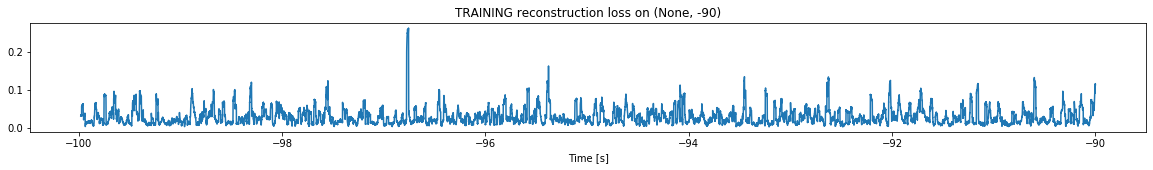

Finished training, median of the log(loss) is:  -1.6174851451871828
<--------
Entering sections:  (-80, -70)
-------->
Training for section:  (-90, -80)


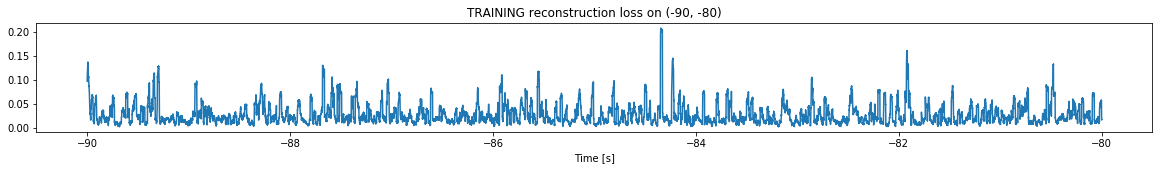

Finished training, median of the log(loss) is:  -1.6717349673184576
Triggering for section:  (-80, -70)
Using this median for triggering: -1.6174851451871828
Triggering threshold is:  5.0


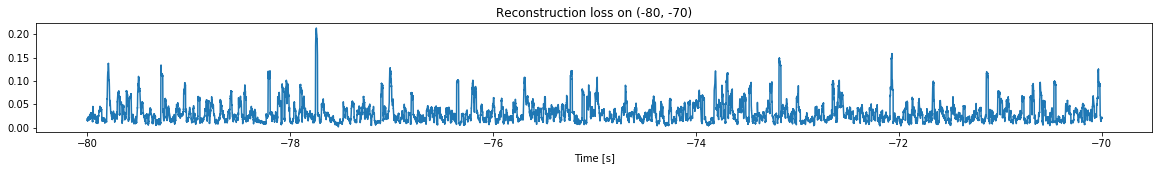

<--------
Entering sections:  (-70, -60)
-------->
Training for section:  (-80, -70)


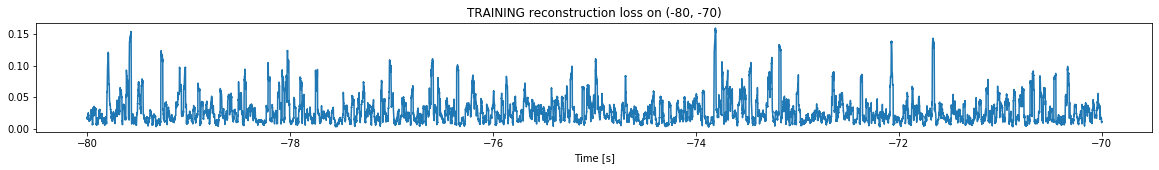

Finished training, median of the log(loss) is:  -1.639387844736873
Triggering for section:  (-70, -60)
Using this median for triggering: -1.6717349673184576
Triggering threshold is:  4.52


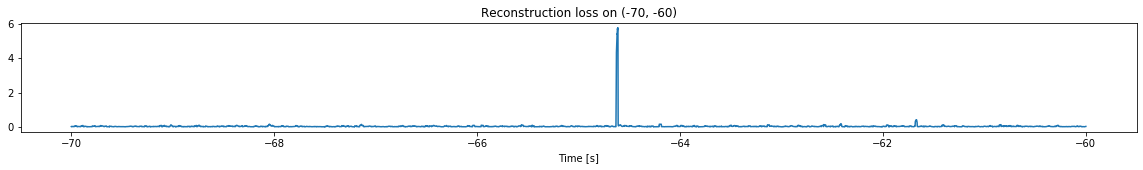

<--------
Entering sections:  (-60, -50)
-------->
Training for section:  (-70, -60)


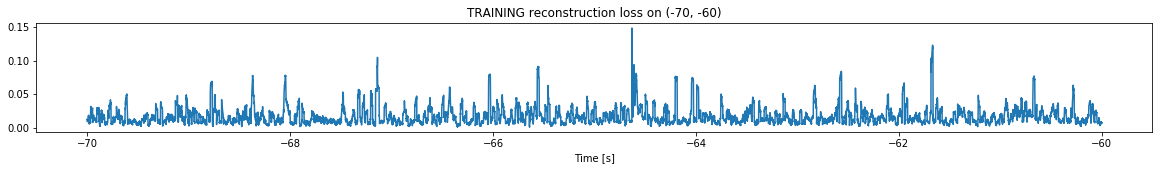

Finished training, median of the log(loss) is:  -1.8536777134212703
Triggering for section:  (-60, -50)
Using this median for triggering: -1.639387844736873
Triggering threshold is:  4.04


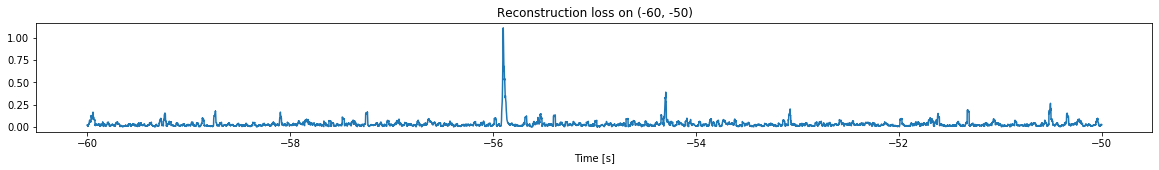

<--------
Entering sections:  (-50, -40)
-------->
Training for section:  (-60, -50)


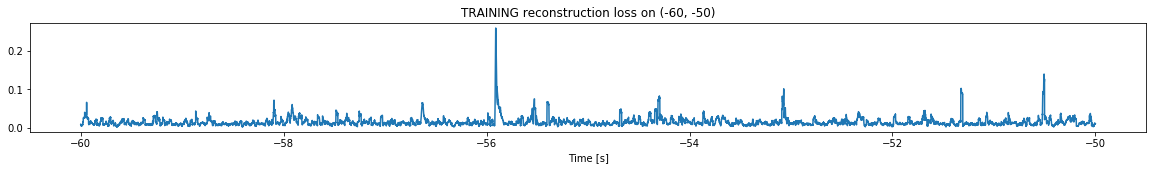

Finished training, median of the log(loss) is:  -1.9182887412219305
Triggering for section:  (-50, -40)
Using this median for triggering: -1.8536777134212703
Triggering threshold is:  3.56


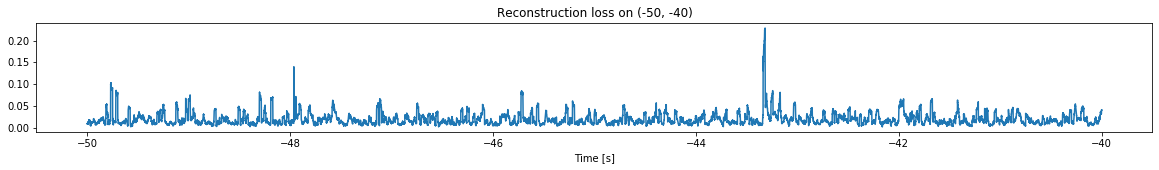

<--------
Entering sections:  (-40, -30)
-------->
Training for section:  (-50, -40)


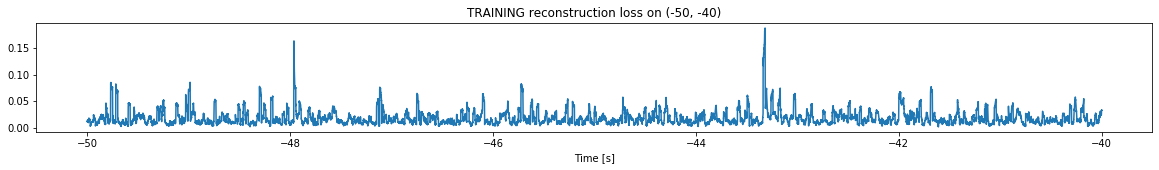

Finished training, median of the log(loss) is:  -1.8296277381582007
Triggering for section:  (-40, -30)
Using this median for triggering: -1.9182887412219305
Triggering threshold is:  3.08


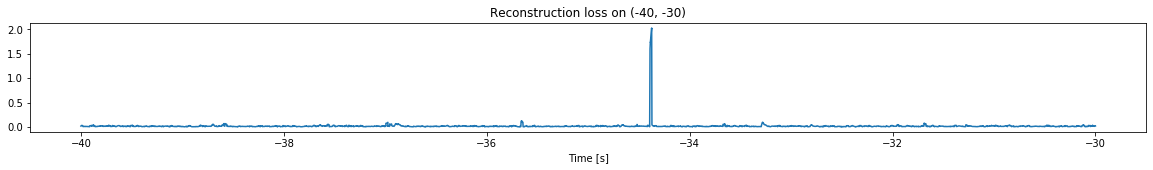

<--------
Entering sections:  (-30, -20)
-------->
Training for section:  (-40, -30)


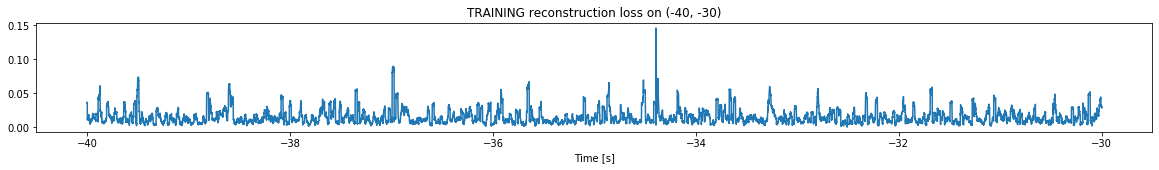

Finished training, median of the log(loss) is:  -1.898202161036111
Triggering for section:  (-30, -20)
Using this median for triggering: -1.8296277381582007
Triggering threshold is:  2.6


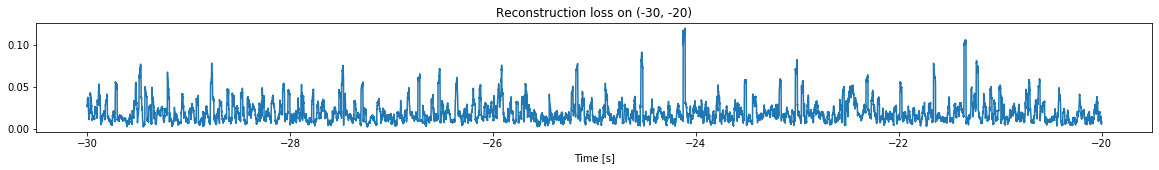

<--------
Entering sections:  (-20, -10)
-------->
Training for section:  (-30, -20)


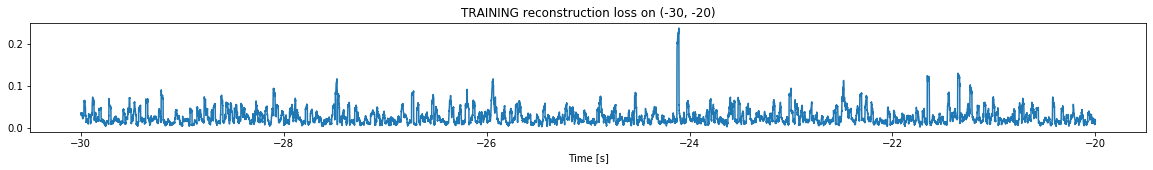

Finished training, median of the log(loss) is:  -1.683353736969086
Triggering for section:  (-20, -10)
Using this median for triggering: -1.898202161036111
Triggering threshold is:  2.6


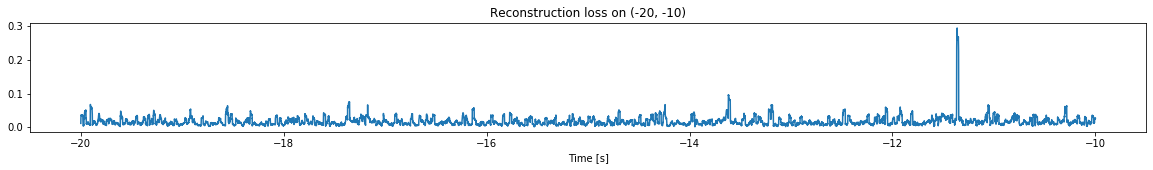

<--------
Entering sections:  (-10, 0)
-------->
Training for section:  (-20, -10)


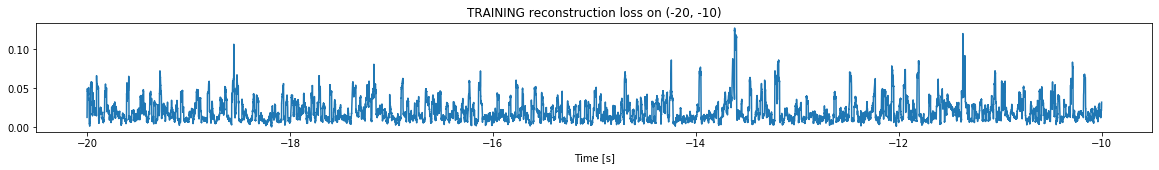

Finished training, median of the log(loss) is:  -1.775305354196374
Triggering for section:  (-10, 0)
Using this median for triggering: -1.683353736969086
Triggering threshold is:  2.6


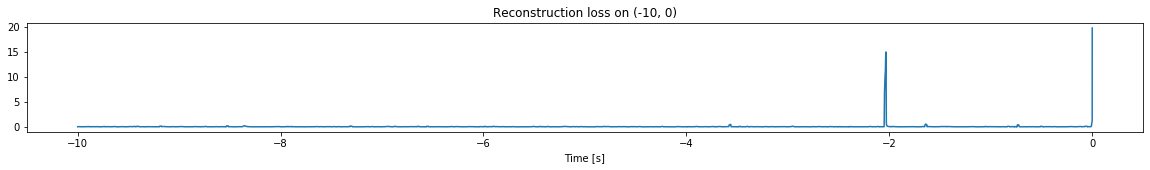

Other trigger time:  [-2.0335]
Their log loss values are:  [2.86019518]


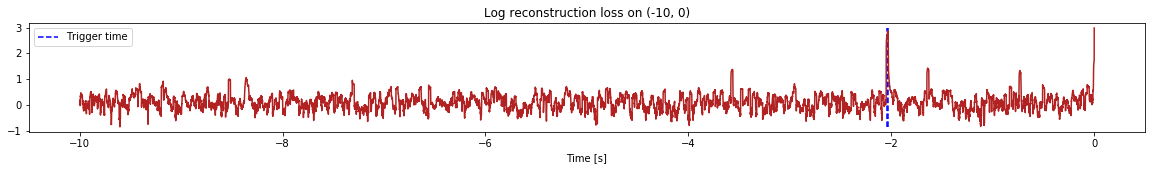

Triggered at:  [-2.0335]
Latent coordinates are:  [[ 9.234608 20.549171 -1.      ]]
latent_coor's shape:  (1, 3)
Latent_normal_coord's shape:  (99998, 3)


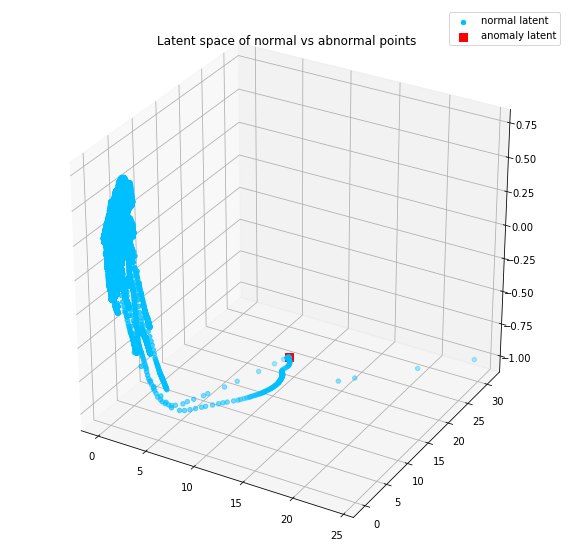

<--------


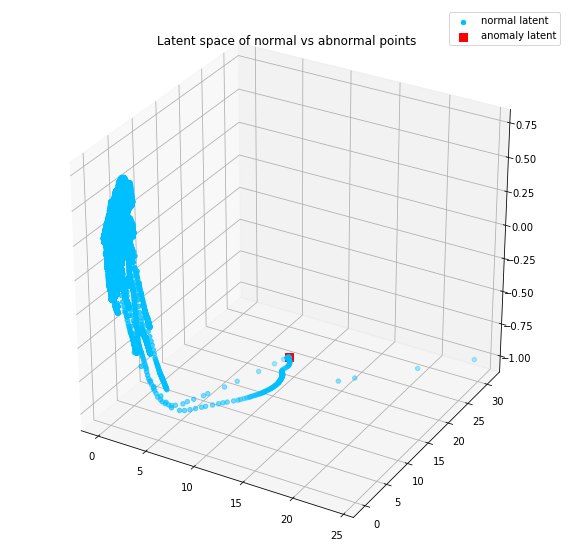

Finished simulation, all the triggered times are:  [-2.0335]

All latent coordinate:  [[ 9.234608 20.549171 -1.      ]]


In [40]:
simulation("./data/Ramp29/", 10, (-100,0), -14)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (899800, 12)
Flushing input history
Number of sections: 9
Number of triggering sections 9
List of trigger thresholds:  [0, 0, 5.0, 4.6, 4.2, 3.8, 3.4000000000000004, 3.0, 2.6]
Entering sections:  (-90, -80)
-------->
Entering sections:  (-80, -70)
-------->
Training for section:  (None, -80)


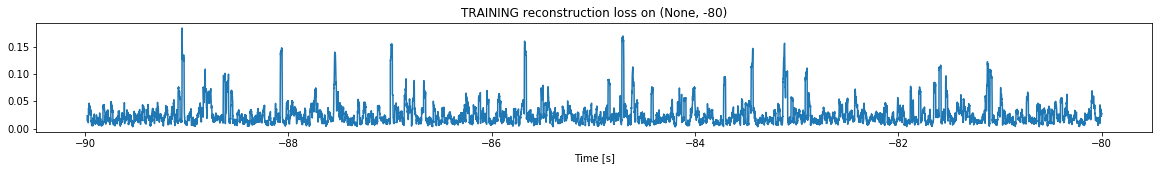

Finished training, median of the log(loss) is:  -1.7039854346909755
<--------
Entering sections:  (-70, -60)
-------->
Training for section:  (-80, -70)


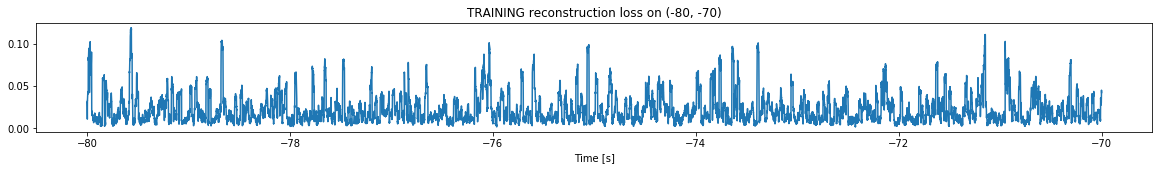

Finished training, median of the log(loss) is:  -1.7575221654025723
Triggering for section:  (-70, -60)
Using this median for triggering: -1.7039854346909755
Triggering threshold is:  5.0


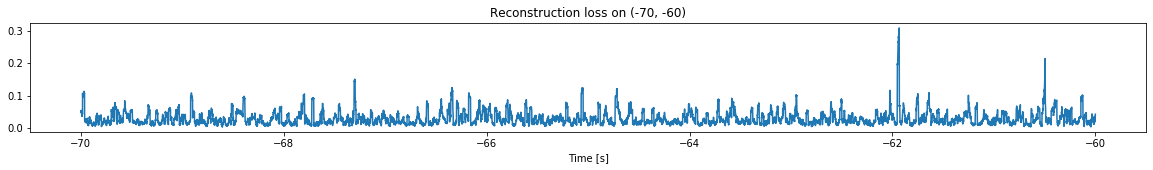

<--------
Entering sections:  (-60, -50)
-------->
Training for section:  (-70, -60)


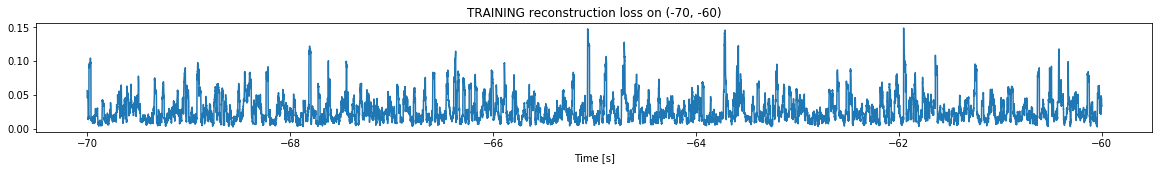

Finished training, median of the log(loss) is:  -1.653301989566101
Triggering for section:  (-60, -50)
Using this median for triggering: -1.7575221654025723
Triggering threshold is:  4.6


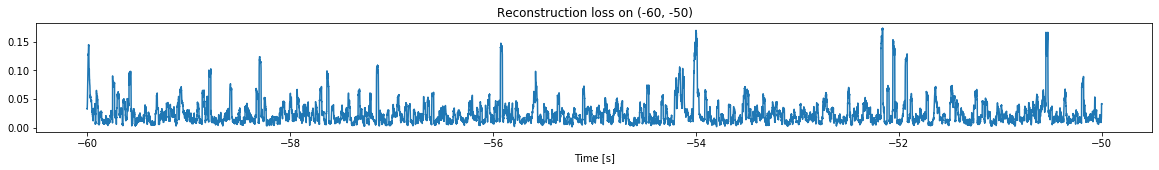

<--------
Entering sections:  (-50, -40)
-------->
Training for section:  (-60, -50)


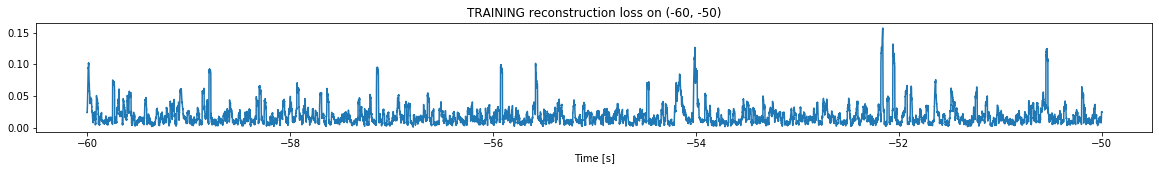

Finished training, median of the log(loss) is:  -1.8423431979141425
Triggering for section:  (-50, -40)
Using this median for triggering: -1.653301989566101
Triggering threshold is:  4.2


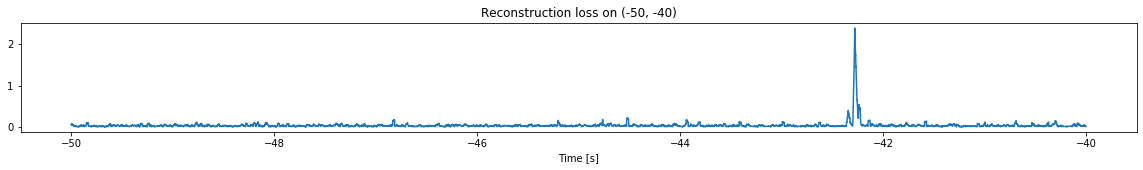

<--------
Entering sections:  (-40, -30)
-------->
Training for section:  (-50, -40)


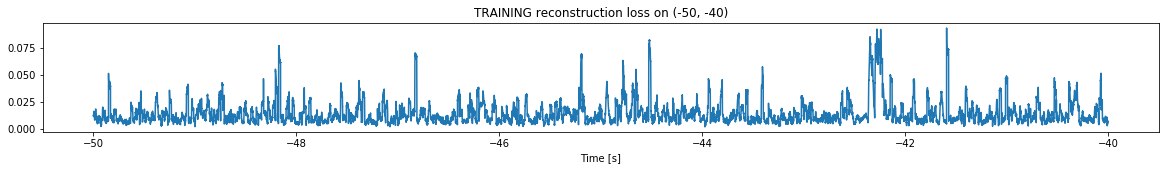

Finished training, median of the log(loss) is:  -1.9538466369947933
Triggering for section:  (-40, -30)
Using this median for triggering: -1.8423431979141425
Triggering threshold is:  3.8


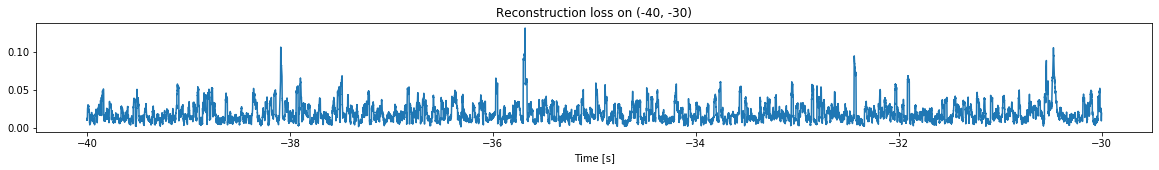

<--------
Entering sections:  (-30, -20)
-------->
Training for section:  (-40, -30)


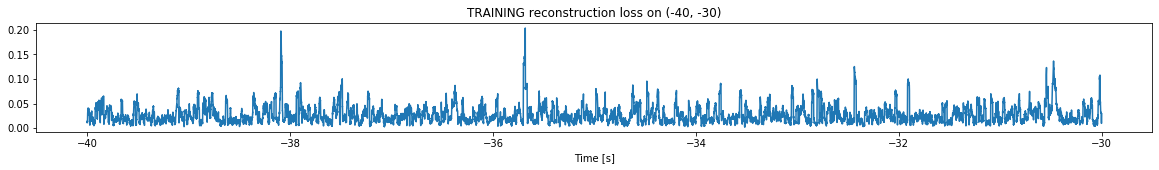

Finished training, median of the log(loss) is:  -1.6371223055883886
Triggering for section:  (-30, -20)
Using this median for triggering: -1.9538466369947933
Triggering threshold is:  3.4000000000000004


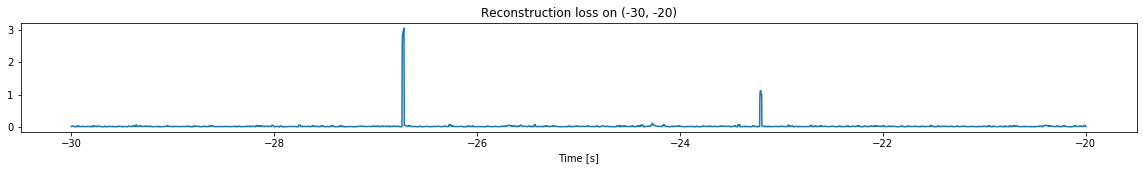

<--------
Entering sections:  (-20, -10)
-------->
Training for section:  (-30, -20)


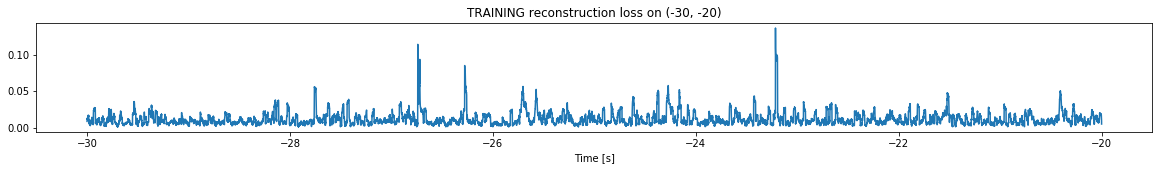

Finished training, median of the log(loss) is:  -2.0156493772587414
Triggering for section:  (-20, -10)
Using this median for triggering: -1.6371223055883886
Triggering threshold is:  3.0


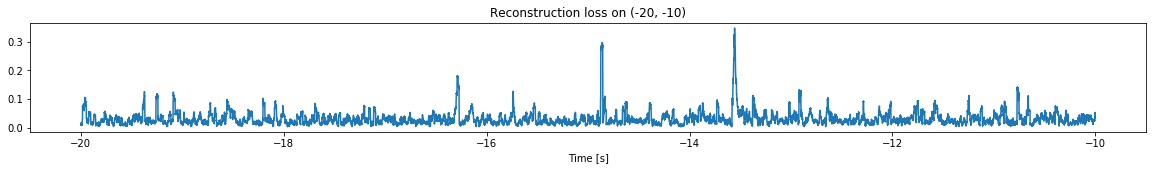

<--------
Entering sections:  (-10, 0)
-------->
Training for section:  (-20, -10)


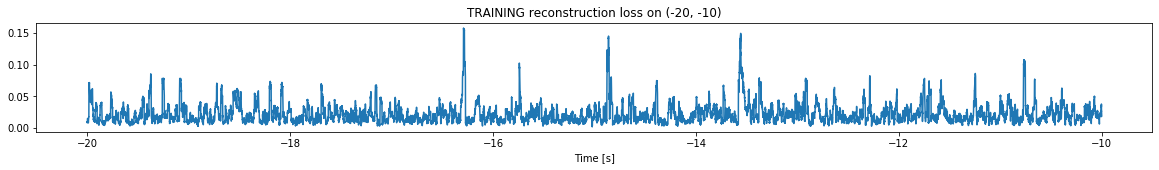

Finished training, median of the log(loss) is:  -1.733037589086321
Triggering for section:  (-10, 0)
Using this median for triggering: -2.0156493772587414
Triggering threshold is:  2.6


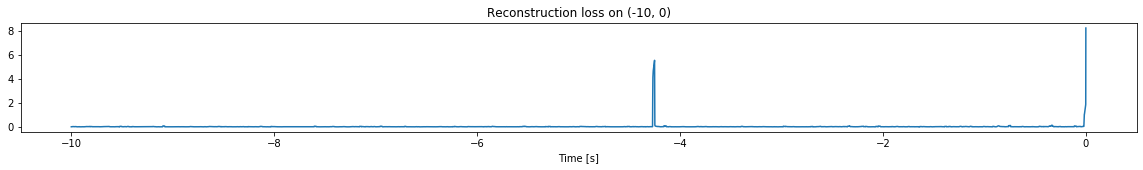

Other trigger time:  [-4.251]
Their log loss values are:  [2.76010168]


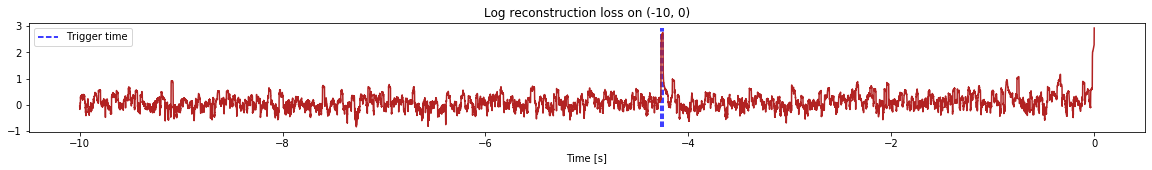

Triggered at:  [-4.251]
Latent coordinates are:  [[ 9.157226   8.207105  11.1297655]]
latent_coor's shape:  (1, 3)
Latent_normal_coord's shape:  (99998, 3)


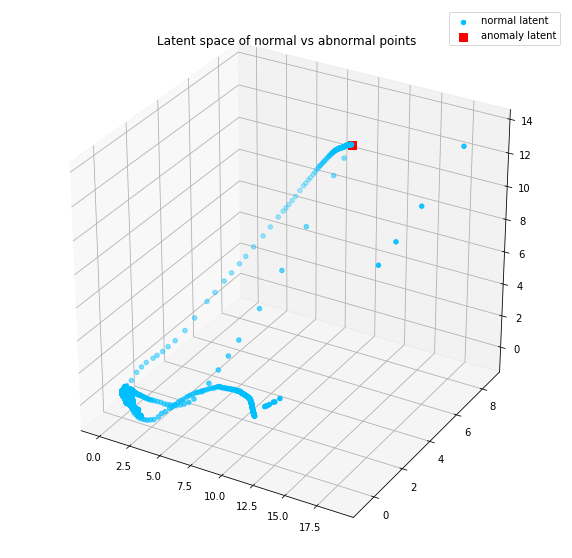

<--------


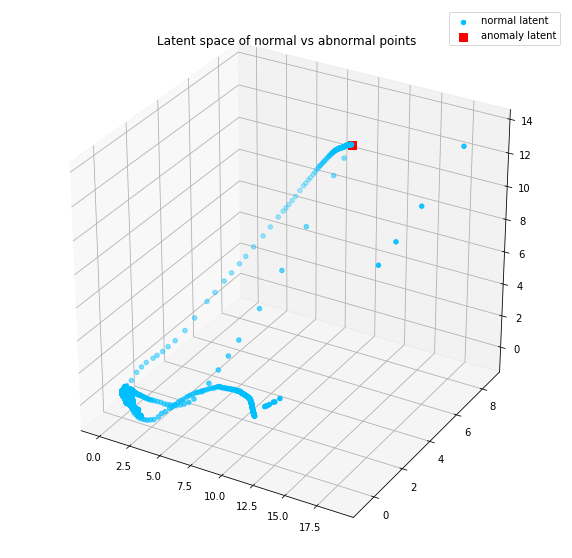

Finished simulation, all the triggered times are:  [-4.251]

All latent coordinate:  [[ 9.157226   8.207105  11.1297655]]


In [41]:
simulation("./data/Ramp5/", 10, (-90,0), 0)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (1199800, 12)
Flushing input history
Number of sections: 12
Number of triggering sections 8
List of trigger thresholds:  [0, 0, 5.0, 4.52, 4.04, 3.56, 3.08, 2.6]
Entering sections:  (-120, -110)
-------->
Entering sections:  (-110, -100)
-------->
Training for section:  (None, -110)


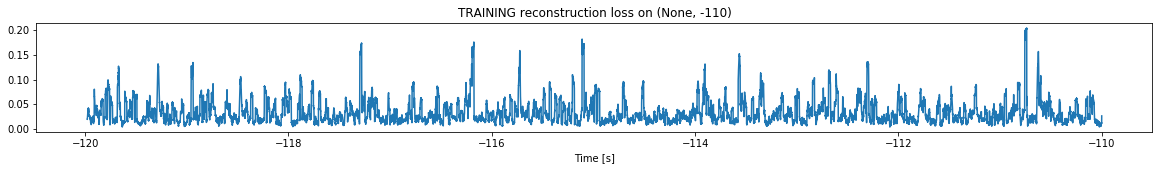

Finished training, median of the log(loss) is:  -1.5687538351496069
<--------
Entering sections:  (-100, -90)
-------->
Training for section:  (-110, -100)


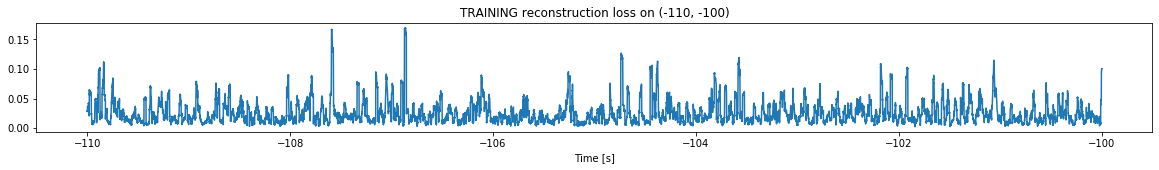

Finished training, median of the log(loss) is:  -1.695286091910413
Triggering for section:  (-100, -90)
Using this median for triggering: -1.5687538351496069
Triggering threshold is:  5.0


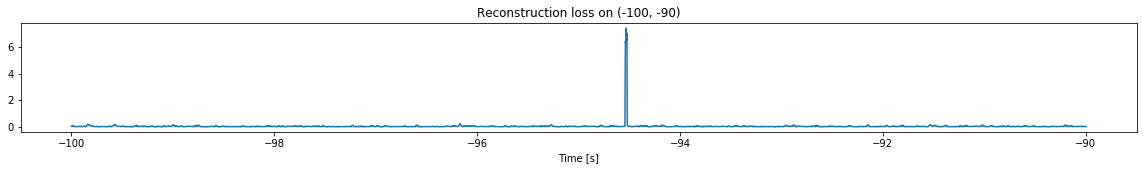

<--------
Entering sections:  (-90, -80)
-------->
Training for section:  (-100, -90)


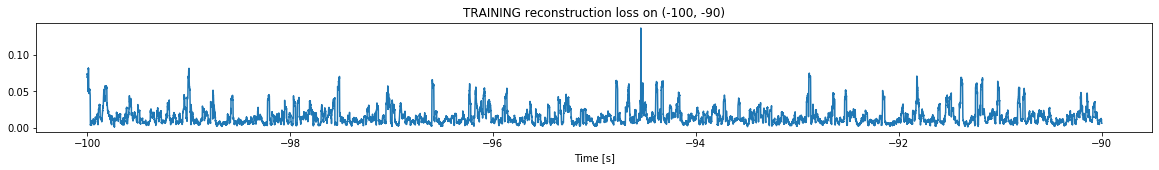

Finished training, median of the log(loss) is:  -1.9149846671322999
Triggering for section:  (-90, -80)
Using this median for triggering: -1.695286091910413
Triggering threshold is:  4.52


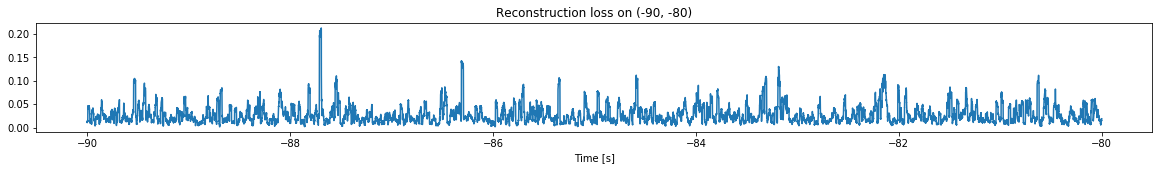

<--------
Entering sections:  (-80, -70)
-------->
Training for section:  (-90, -80)


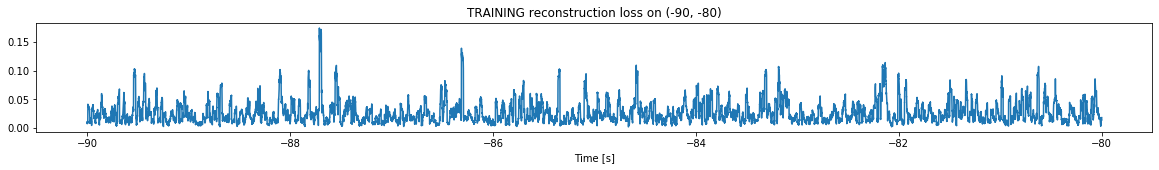

Finished training, median of the log(loss) is:  -1.6581974813677072
Triggering for section:  (-80, -70)
Using this median for triggering: -1.9149846671322999
Triggering threshold is:  4.04


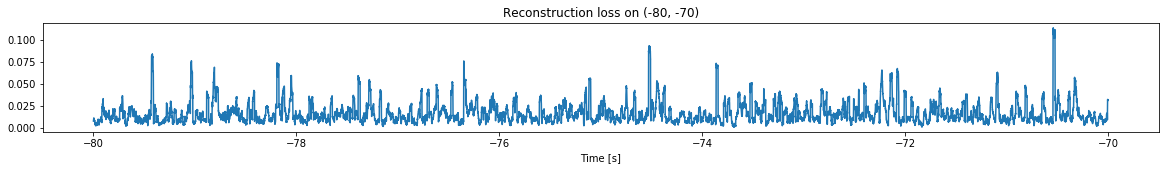

<--------
Entering sections:  (-70, -60)
-------->
Training for section:  (-80, -70)


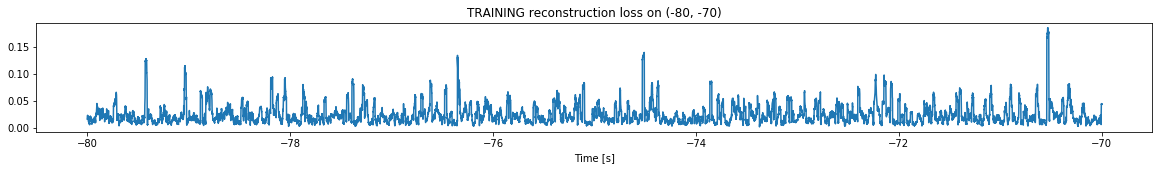

Finished training, median of the log(loss) is:  -1.6960970016959764
Triggering for section:  (-70, -60)
Using this median for triggering: -1.6581974813677072
Triggering threshold is:  3.56


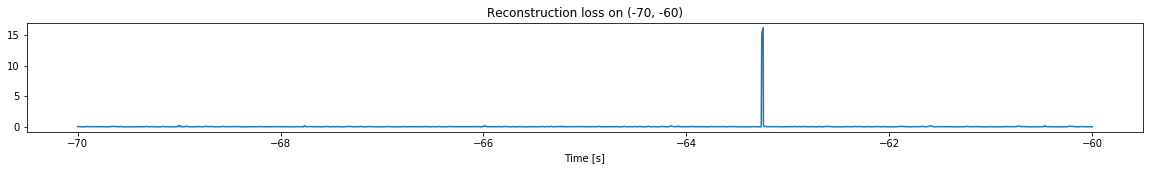

<--------
Entering sections:  (-60, -50)
-------->
Training for section:  (-70, -60)


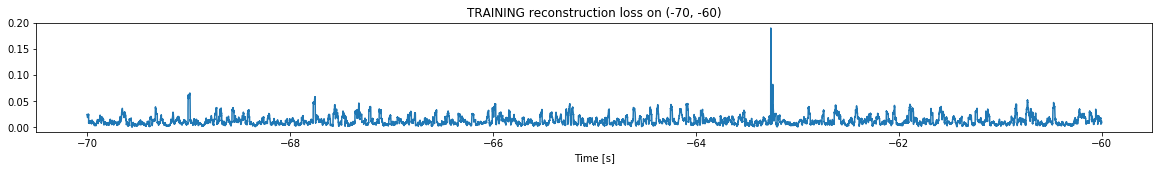

Finished training, median of the log(loss) is:  -1.9722823773824194
Triggering for section:  (-60, -50)
Using this median for triggering: -1.6960970016959764
Triggering threshold is:  3.08


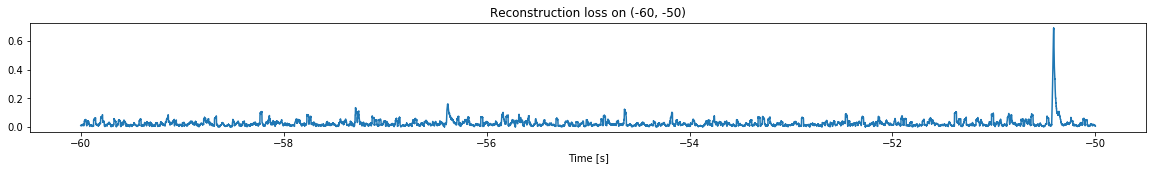

<--------
Entering sections:  (-50, -40)
-------->
Training for section:  (-60, -50)


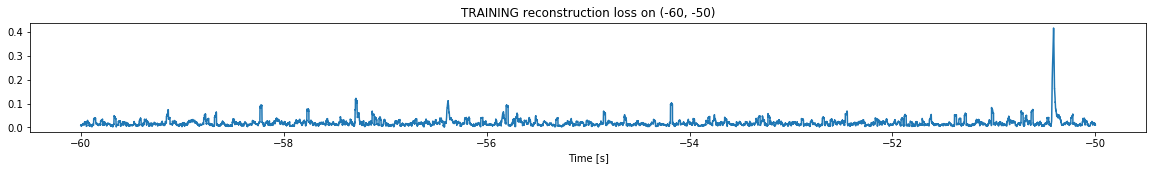

Finished training, median of the log(loss) is:  -1.8147297643003863
Triggering for section:  (-50, -40)
Using this median for triggering: -1.9722823773824194
Triggering threshold is:  2.6


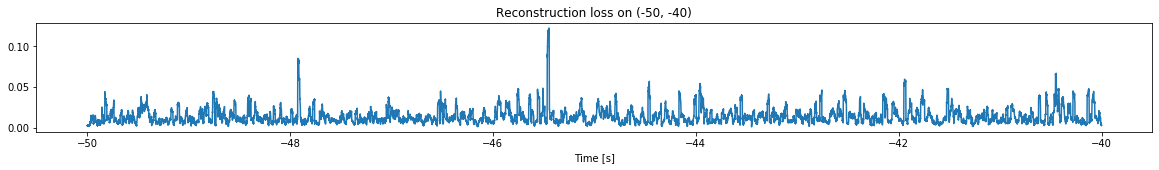

<--------
Entering sections:  (-40, -30)
-------->
Training for section:  (-50, -40)


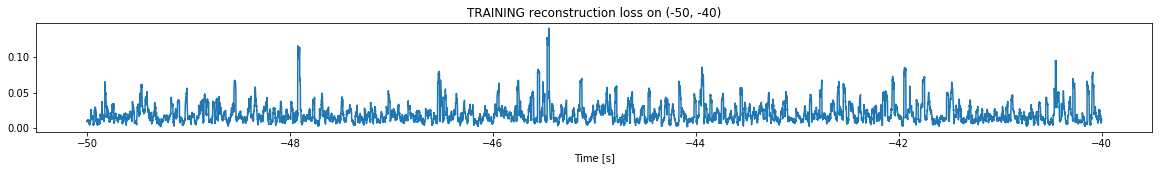

Finished training, median of the log(loss) is:  -1.7714053989047494
Triggering for section:  (-40, -30)
Using this median for triggering: -1.8147297643003863
Triggering threshold is:  2.6


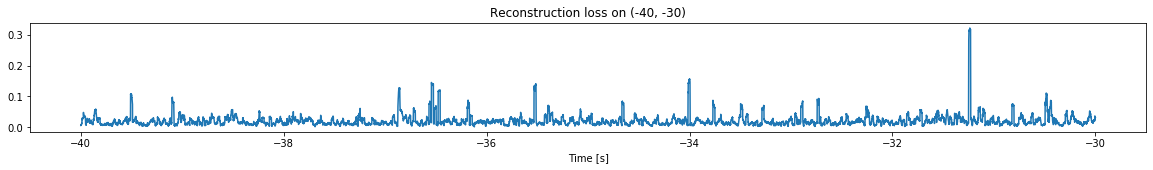

<--------
Entering sections:  (-30, -20)
-------->
Training for section:  (-40, -30)


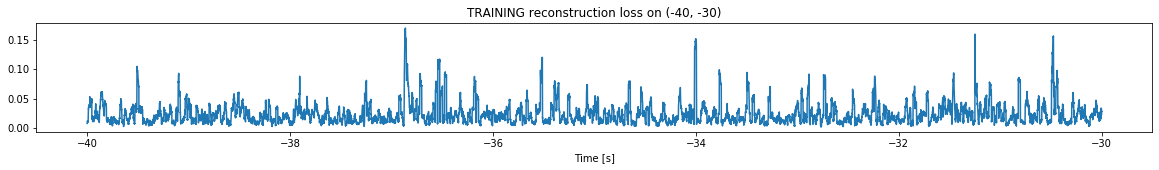

Finished training, median of the log(loss) is:  -1.7064482574406126
Triggering for section:  (-30, -20)
Using this median for triggering: -1.7714053989047494
Triggering threshold is:  2.6


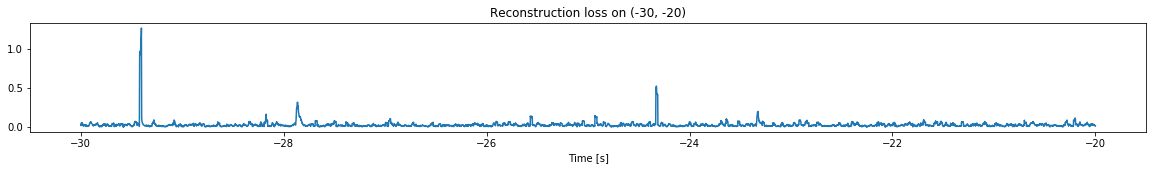

<--------
Entering sections:  (-20, -10)
-------->
Training for section:  (-30, -20)


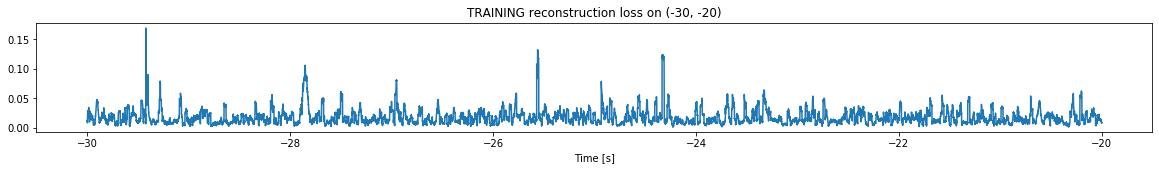

Finished training, median of the log(loss) is:  -1.816984324906063
Triggering for section:  (-20, -10)
Using this median for triggering: -1.7064482574406126
Triggering threshold is:  2.6


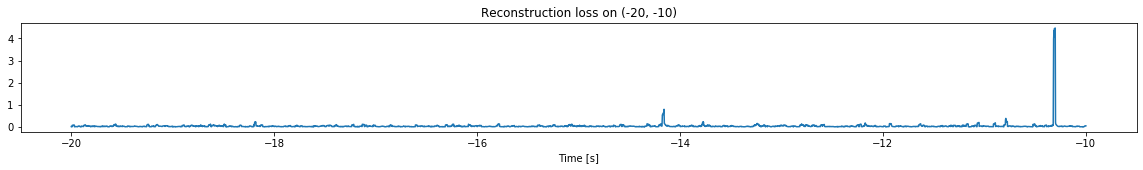

<--------
Entering sections:  (-10, 0)
-------->
Training for section:  (-20, -10)


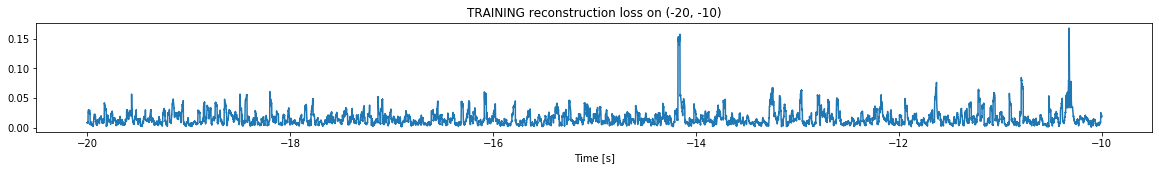

Finished training, median of the log(loss) is:  -1.8994251925751282
Triggering for section:  (-10, 0)
Using this median for triggering: -1.816984324906063
Triggering threshold is:  2.6


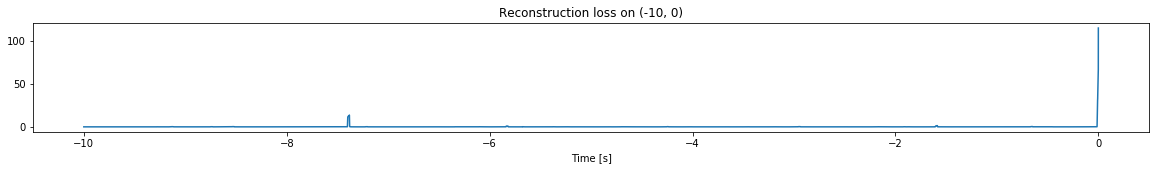

Other trigger time:  [-7.3820996]
Their log loss values are:  [2.95164035]


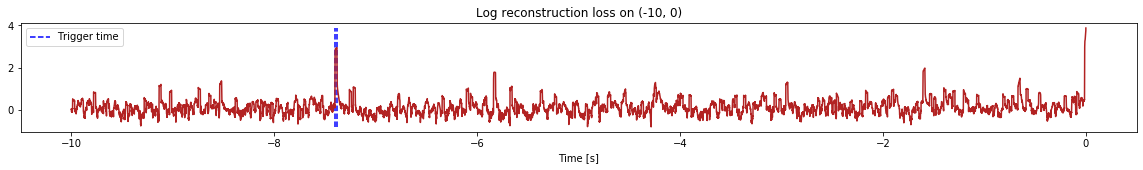

Triggered at:  [-7.3820996]
Latent coordinates are:  [[137.07585   55.296875  35.818512]]
latent_coor's shape:  (1, 3)
Latent_normal_coord's shape:  (99998, 3)


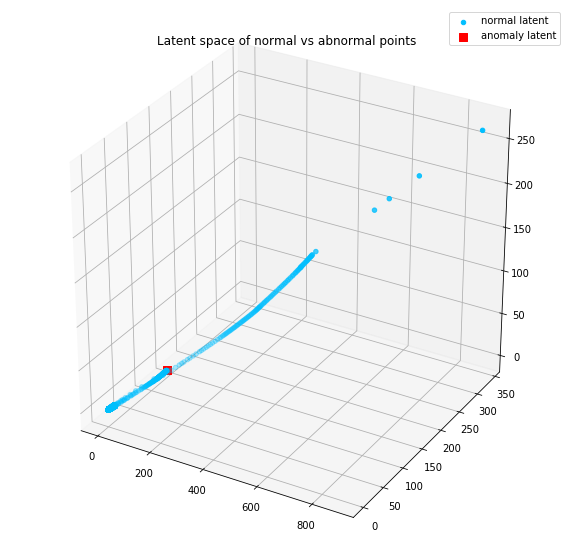

<--------


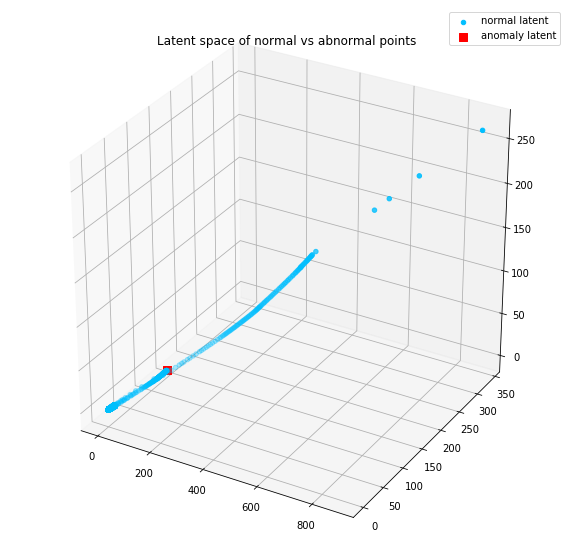

Finished simulation, all the triggered times are:  [-7.3820996]

All latent coordinate:  [[137.07585   55.296875  35.818512]]


In [42]:
simulation("./data/Ramp30/", 10, (-120,0), -33.2)